In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
# from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
# from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Activation
from keras.layers import SpatialDropout1D
from sklearn.model_selection import KFold
from keras.regularizers import l2


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATN/DATA/DataV1/data_datn_trainV1_numberlable_6_1.csv')
#df.sentences=df.sentences.astype(str)
#df.info()
df.Emotion.value_counts()

# new_data = pd.DataFrame()
# new_data['title'] = df.Posts
# new_data['label'] = df['Emotion']
# new_data.head()

5    1846
1    1748
2    1647
0    1162
4     463
3     376
Name: Emotion, dtype: int64

In [ ]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
df['Emotion'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Label', 
                                                                title='Number complaints in each label')

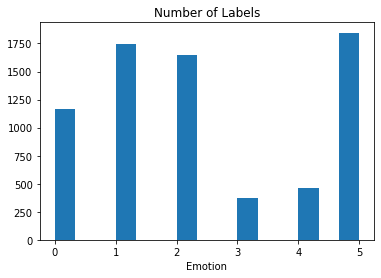

In [ ]:
plt.hist(df['Emotion'], bins=15)
plt.title('Number of Labels')
plt.xlabel('Emotion')
plt.savefig('/content/drive/MyDrive/DATN/DATA/total_6Label.png',bbox_inches='tight')
plt.show()

In [ ]:
df.Posts=df.Posts.astype(str)
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 500
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['Posts'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['Posts'].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = pd.get_dummies(df['Emotion']).values


In [ ]:
print('Shape of data tensor:', X.shape)
print(X[0])

Shape of data tensor: (7242, 50)
[443  45 129   1  41   4 447 375 137  24 114  53  41   1 177   7  89   1
  96  38 184  41 116  82  75   9 120 217   1  26 115   2 139  75  90   6
 399   9   1  62 440  73 348 159   6  15   1 172 197 271]


In [ ]:
print(word_index)

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(X[0]))
#print('---')
#print(X[0])

tương ở đâu mình vì không dám dùng chính để tâm sự vì mình sợ người thân mình họ sẽ buồn vì chưa ai chuyện của ông chồng mình nhưng đây là câu chuyện thật và phụ của mình cảm ơn các bệnh nghe và cho mình lời động viên


In [ ]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.97):
      print("\nReached 97% accuracy so cancelling training!")
      self.model.stop_training = True

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           50000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 168,022
Trainable params: 168,022
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/50
163/163 [==============================] - 46s 245ms/step - loss: 1.6032 - accuracy: 0.3110 - val_loss: 1.4930 - val_accuracy: 0.3431
Epoch 2/50
163/163 [==============================] - 41s 249ms/step - loss: 1.4197 - accuracy: 0.4161 - val_loss: 1.3638 - val_accuracy: 0.4397
Epoch 3/50
163/163 [==============================] - 40s 244ms/step - loss: 1.3060 - accuracy: 0.4821 - val_loss: 1.3245 - val_accuracy: 0.4569
Epoch 4/50
163/163 [==============================] - 39s 240ms/step - loss: 1.2408 - accuracy: 0.5135 - val_loss: 1.3229 - val_accuracy: 0.4552
Epoch 5/50
163/163 [==============================] - 39s 242ms/step - loss: 1.1982 - accuracy: 0.5348 - val_loss: 1.3121 - val_accuracy: 0.4741
Epoch 6/50
163/163 [==============================] - 39s 239ms/step - loss: 1.1726 - accuracy: 0.5456 - val_loss: 1.2994 - val_accuracy: 0.4621
Epoch 7/50
163/163 [==============================] - 40s 243ms/step - loss: 1.1461 - accuracy: 0.5553 - val_loss: 1.2955 - val_ac

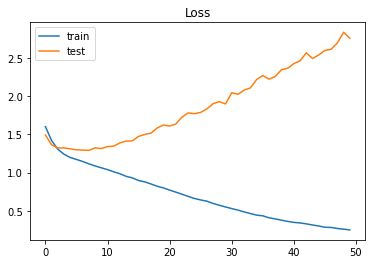

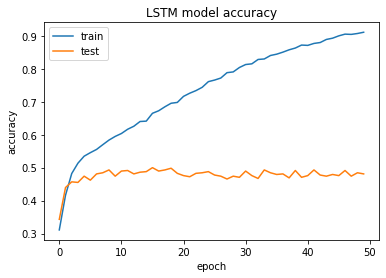

In [ ]:
n_split=3
for train_index,test_index in KFold(n_split).split(X):
  X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

callbacks = myCallback()
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.05))
model.add(LSTM(128, dropout=0.15, recurrent_dropout=0.1))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])
model.summary()
epochs = 50
batch_size = 32
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

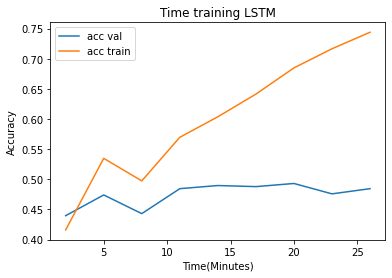

In [ ]:
import matplotlib.pyplot as plt
# time = [15,30,45,60,75,90,105,120,135,150,175]
time = [2,5,8,11,14,17,20,23,26]
acc_train = [0.832,0.835,0.839,0.842,0.844,0.849,0.852,0.853,0.857,0.861,0.864]
acc_test = [0.789,0.792,0.796,0.801,0.803,0.805,0.808,0.809,0.812,0.811,0.813]
val_acc= [0.4397,0.4741,0.4431,0.4845,0.4897, 0.4879,0.4931,0.4759,0.4845 ]
acc = [0.4161 ,0.5348 ,0.4974 ,0.5697 ,0.6037,0.6413 ,0.6848 ,0.7165 ,0.7439 ]
plt.plot(time,val_acc)
plt.plot(time,acc)
plt.title('Time training LSTM')
plt.ylabel('Accuracy')
plt.xlabel('Time(Minutes)')
plt.legend(['acc val', 'acc train'], loc='upper left')
plt.savefig('/content/drive/MyDrive/DATN/KQ/ModelV1/time_train.png',bbox_inches='tight')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/DATN/KQ/ModelV4/model1.h5")

In [ ]:
new_complaint = ['tôi và vợ tôi lấy nhau đã được hơn năm con_gái của chúng_tôi cũng đã được tháng rồi gia_đình tôi vốn là gia_đình có nề_nếp gia phong không quá cứng_nhắc nhưng trên bảo dưới phải nghe không được cãi lời tôi là con_một nên vợ_chồng tôi lấy nhau thì xác_định sẽ ở với bố_mẹ ngày tôi và vợ tôi còn yêu nhau đến nhà cô ấy chơi tôi thấy nề_nếp sinh_hoạt và cách ứng_xử của mọi người với nhau trong gia_đình khác hẳn nhà tôi người_nhà cô ấy khá thoải_mái người nhỏ có_thể trêu đùa người_lớn hầu_như không có khoảng_cách nào so với hai bên gia_đình phong_cách sống hoàn_toàn trái_ngược nhau vậy nên sau khi về nhà tôi làm dâu có nhiều chuyện vợ tôi gần như không thích_ứng được cô ấy cũng cố_gắng thay_đổi theo nề_nếp nhà chồng nhưng có nhiều việc cô ấy vẫn cho rằng không cần_thiết chính vì lẽ đó vợ tôi hay bị mẹ chồng phiền trách giáo huấn cách đây mấy hôm vợ tôi có báo tôi cuối tuần em đưa con về nhà ngoại chơi tầm thứ em về nhé tôi cũng đã dặn_dò vợ tôi kỹ_càng em cứ về đi nhưng trước khi đi nhớ xin phép bố_mẹ đã nhé chẳng hiểu sao hôm thứ khi tôi đang ở cơ_quan thì mẹ tôi gọi điện nhà này rốt_cuộc có ai coi ông bà_già này ra gì nữa không rồi cúp máy ngang tôi đoán có chuyện không hay nên đã gọi điện hỏi_vợ sáng em về ngoại không xin phép bố_mẹ à']
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
seq = tokenizer.texts_to_sequences(new_complaint)
padded = sequence.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Chán ghét', 'Thích thú', 'Buồn bã', 'Sợ hãi', 'Giận dữ', 'Khác']
print(pred, labels[np.argmax(pred)])

[[0.1429     0.14621346 0.13663314 0.14479676 0.13767104 0.1501667
  0.14161883]] Khác
